# Semi-Supervised VAE Demo

This notebook demonstrates how to:
1. Train a semi-supervised VAE
2. Evaluate its performance
3. Compare with unsupervised baseline

## Training

Run the training script from terminal or notebook:

In [ ]:
# Train with default parameters (recommended for first try)
!python ../scripts/train_semi_supervised.py --latent_dim 16

In [ ]:
# Advanced: customize training parameters
!python ../scripts/train_semi_supervised.py \
    --latent_dim 16 \
    --stage1_epochs 300 \
    --stage2_epochs 200 \
    --supervised_weight 0.3 \
    --kld_weight 0.00025 \
    --batch_size 16

## Evaluation

After training, evaluate the model using Random Forest:

In [5]:
# Replace with your actual checkpoint path
checkpoint_path = "../checkpoints/semi_supervised_vae/semi_supervised_20251124_210846/final.pth"

!python ../scripts/evaluate_semi_supervised.py \
    --checkpoint {checkpoint_path} \
    --latent_dim 16

Using device: cuda

Traceback (most recent call last):
  File "/home/luiz/Documentos/ufmg/nanocomp/tga-feature-extraction/notebooks/../scripts/evaluate_semi_supervised.py", line 279, in <module>
    main(args)
  File "/home/luiz/Documentos/ufmg/nanocomp/tga-feature-extraction/notebooks/../scripts/evaluate_semi_supervised.py", line 94, in main
    dataset = TGADataset(data_path='./data/tga_afm/data.npz', mode='feature')
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/luiz/Documentos/ufmg/nanocomp/tga-feature-extraction/src/dataset.py", line 14, in __init__
    data = np.load(data_path)
           ^^^^^^^^^^^^^^^^^^
  File "/home/luiz/Documentos/ufmg/nanocomp/tga-feature-extraction/.venv/lib/python3.12/site-packages/numpy/lib/_npyio_impl.py", line 454, in load
    fid = stack.enter_context(open(os.fspath(file), "rb"))
                              ^^^^^^^^^^^^^^^^^^^^^^^^^^^
FileNotFoundError: [Errno 2] No such file or directory: './data/tga_af

## Load and Inspect Results

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load evaluation results
results_dir = "../checkpoints/semi_supervised_vae/semi_supervised_20251124_210846"
results = pd.read_csv(f"{results_dir}/evaluation_results.csv")

print("Semi-Supervised VAE Results:")
print(results.to_string(index=False))
print(f"\nAverage R²: {results['R² Score'].mean():.4f}")

Semi-Supervised VAE Results:
             Target  R² Score          MSE          MAE
  Min Ferret Median  0.434695 2.078545e+10 1.030652e+05
Max Ferret Kurtosis  0.311610 7.490298e+18 2.057312e+09
    Volume Skewness  0.271011 8.756306e-02 2.366912e-01
Max Ferret Variance  0.168391 1.322968e+08 9.366868e+03
Max Ferret Skewness  0.145854 6.566729e+02 1.728790e+01
    Max Ferret Mean  0.120118 1.771760e+07 3.442464e+03
      Volume Median  0.102230 2.781388e+05 4.259916e+02
Min Ferret Kurtosis -0.008496 1.386440e+08 7.773916e+03
Min Ferret Skewness -0.123405 3.320034e+00 1.229721e+00
          Area Mean -0.146450 3.716859e+02 1.524815e+01
        Volume Mean -0.159748 1.932771e+01 3.538241e+00
        Height Mean -0.185336 2.098805e+00 1.079623e+00
    Volume Kurtosis -0.231420 1.960114e+04 1.137424e+02
    Min Ferret Mean -0.253948 9.759995e+02 2.018608e+01
Min Ferret Variance -0.262458 2.966569e+03 3.484541e+01
    Height Kurtosis -0.278645 4.364393e+01 4.795573e+00
  Max Ferret Median

## Compare with Baseline

In [2]:
# Load unsupervised baseline results
baseline = pd.read_csv("../results/rf_regression_results.csv")

# Merge results
comparison = pd.merge(
    baseline[['Target', 'R² Score']], 
    results[['Target', 'R² Score']],
    on='Target',
    suffixes=(' (Unsupervised)', ' (Semi-Supervised)')
)

comparison['Improvement'] = comparison['R² Score (Semi-Supervised)'] - comparison['R² Score (Unsupervised)']

print("\nComparison:")
print(comparison.to_string(index=False))

print(f"\nAverage Improvement: {comparison['Improvement'].mean():.4f}")


Comparison:
           Target  R² Score (Unsupervised)  R² Score (Semi-Supervised)  Improvement
Max Ferret Median                 0.263566                   -0.329324    -0.592890
  Max Ferret Mean                 0.202379                    0.120118    -0.082261
  Min Ferret Mean                -0.026288                   -0.253948    -0.227660
Min Ferret Median                -0.059721                    0.434695     0.494415
    Volume Median                -0.168603                    0.102230     0.270832
      Height Mean                -0.177219                   -0.185336    -0.008117
    Height Median                -0.198606                   -0.826497    -0.627891
        Area Mean                -0.209005                   -0.146450     0.062556
      Volume Mean                -0.209685                   -0.159748     0.049938
      Area Median                -0.378144                   -0.949752    -0.571608

Average Improvement: -0.1233


## Visualize Comparison

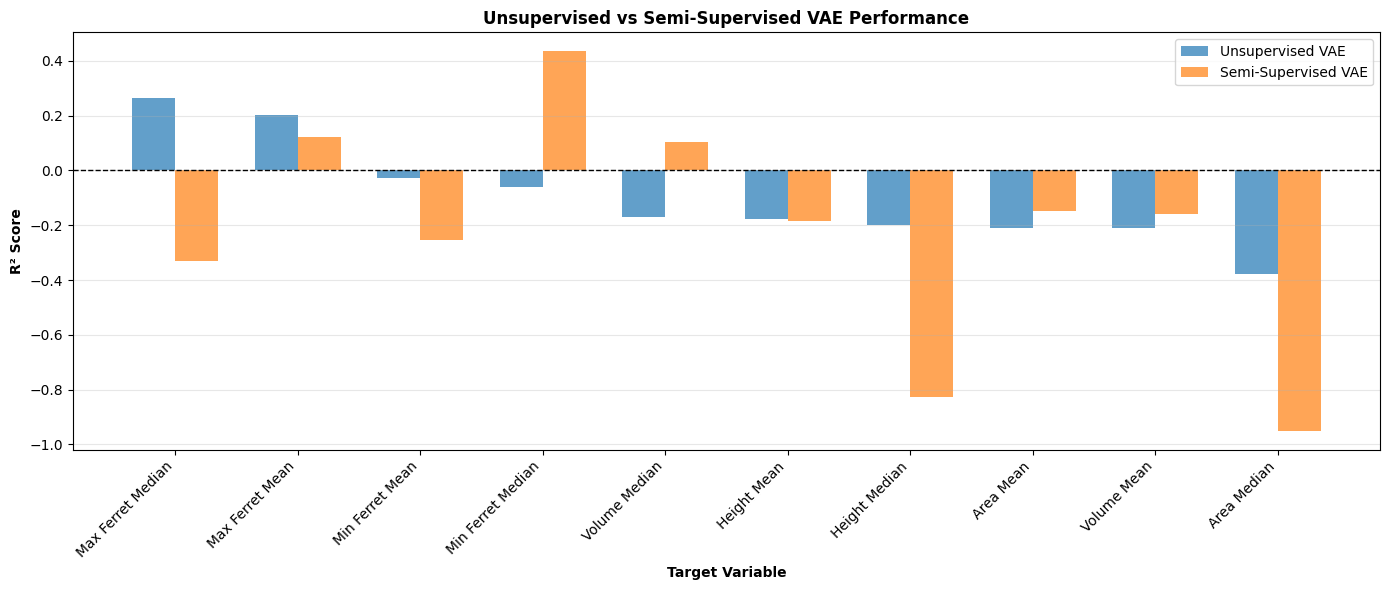

In [3]:
fig, ax = plt.subplots(figsize=(14, 6))

x = range(len(comparison))
width = 0.35

ax.bar([i - width/2 for i in x], comparison['R² Score (Unsupervised)'], 
       width, label='Unsupervised VAE', alpha=0.7)
ax.bar([i + width/2 for i in x], comparison['R² Score (Semi-Supervised)'], 
       width, label='Semi-Supervised VAE', alpha=0.7)

ax.set_xlabel('Target Variable', fontweight='bold')
ax.set_ylabel('R² Score', fontweight='bold')
ax.set_title('Unsupervised vs Semi-Supervised VAE Performance', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison['Target'], rotation=45, ha='right')
ax.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## Generate Predictions for New Data

In [7]:
import torch
import sys
import os

sys.path.append('..')
from models.semi_supervised_vae import SemiSupervisedVAE
from src.dataset import TGADataset

# Load model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SemiSupervisedVAE(compressed_dim=16, num_targets=25)
model.load_checkpoint(checkpoint_path, device)
model.to(device)
model.double()
model.eval()

# Load scaler
scaler = torch.load(f"{results_dir}/scaler.pt")
y_mean = scaler['mean']
y_std = scaler['std']

print("Model loaded successfully!")

Model loaded successfully!


In [9]:
# Make predictions
dataset = TGADataset(data_path='../data/tga_afm/data.npz', mode='feature')

# Get a sample
x_sample, y_true = dataset[0]
x_sample = x_sample.unsqueeze(0).to(device)

# Predict
with torch.no_grad():
    y_pred_norm = model.predict(x_sample)
    y_pred = y_pred_norm * y_std + y_mean  # Denormalize

# Print results
stat_names = ['Mean', 'Variance', 'Skewness', 'Kurtosis', 'Median']
metric_names = ['Min Ferret', 'Max Ferret', 'Height', 'Area', 'Volume']

target_names = []
for metric in metric_names:
    for stat in stat_names:
        target_names.append(f"{metric} {stat}")

print("\nPredictions vs True Values:")
print("-" * 60)
y_true_flat = y_true.flatten()
y_pred_flat = y_pred.cpu().squeeze().numpy()

for name, true_val, pred_val in zip(target_names, y_true_flat, y_pred_flat):
    error = abs(pred_val - true_val)
    rel_error = (error / true_val * 100) if true_val != 0 else 0
    print(f"{name:20s}: True={true_val:8.2f}, Pred={pred_val:8.2f}, "
          f"Error={error:6.2f} ({rel_error:5.1f}%)")


Predictions vs True Values:
------------------------------------------------------------
Min Ferret Mean     : True=  117.76, Pred=  108.46, Error=  9.30 (  7.9%)
Min Ferret Variance : True=  193.52, Pred=  190.74, Error=  2.79 (  1.4%)
Min Ferret Skewness : True=    3.59, Pred=    4.05, Error=  0.46 ( 12.8%)
Min Ferret Kurtosis : True=16987.63, Pred=18244.46, Error=1256.83 (  7.4%)
Min Ferret Median   : True=92000.57, Pred=244647.92, Error=152647.35 (165.9%)
Max Ferret Mean     : True= 5480.00, Pred= 9649.78, Error=4169.78 ( 76.1%)
Max Ferret Variance : True=15320.71, Pred=24661.21, Error=9340.50 ( 61.0%)
Max Ferret Skewness : True=   12.63, Pred=   34.07, Error= 21.44 (169.8%)
Max Ferret Kurtosis : True=493920878.49, Pred=2910578384.95, Error=2416657506.46 (489.3%)
Max Ferret Median   : True=35961654787.27, Pred=3505366005944.93, Error=3469404351157.66 (9647.5%)
Height Mean         : True=    2.06, Pred=    3.95, Error=  1.89 ( 91.9%)
Height Variance     : True=    2.31, Pred=    4.

## Hyperparameter Tuning

Try different configurations to optimize performance:

In [ ]:
# Experiment with different latent dimensions
for latent_dim in [8, 16, 24, 32]:
    print(f"\nTraining with latent_dim={latent_dim}...")
    !python ../scripts/train_semi_supervised.py \
        --latent_dim {latent_dim} \
        --stage1_epochs 200 \
        --stage2_epochs 150

In [ ]:
# Experiment with different supervised weights
for sup_weight in [0.1, 0.3, 0.5, 0.7]:
    print(f"\nTraining with supervised_weight={sup_weight}...")
    !python ../scripts/train_semi_supervised.py \
        --latent_dim 16 \
        --supervised_weight {sup_weight} \
        --stage1_epochs 200 \
        --stage2_epo## Architecture Details

### Model: `SemiSupervisedVAE`

**Encoder:**
```
Input (2, 1024) → Conv1d layers → Bottleneck (4, 128) → FC → Latent (16)
```

**Decoder:**
```
Latent (16) → FC → Expand (4, 128) → ConvTranspose1d layers → Output (2, 1024)
```

**Prediction Head:**
```
Latent (16) → FC(64) → FC(32) → FC(25)
```
Outputs 25 AFM targets: 5 metrics (Min/Max Ferret, Height, Area, Volume) × 5 statistics (Mean, Variance, Skewness, Kurtosis, Median)

### Loss Functions

**Stage 1 (Unsupervised):**
```
L = reconstruction_loss + β × KL_divergence
```

**Stage 2 (Semi-Supervised):**
```
L = (1-α) × [reconstruction_loss + β × KL_divergence] + α × prediction_loss
```

Where:
- β = KL weight (default: 0.00025)
- α = supervised weight (default: 0.3)
chs 150